In [232]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

from astroML.utils import completeness_contamination
from astroML.classification import GMMBayes
from astroML.utils import pickle_results

import corner

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [8,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

In [233]:
file = '../solutions/galaxyquasar.csv'
data= np.genfromtxt(file, delimiter=',', dtype = str)
print(data)

[['u' 'g' 'r' ... 'class' 'z1' 'zerr']
 ['18.97213' '18.53676' '18.5828' ... 'QSO' '0.5228189' '0.0001547483']
 ['19.24592' '17.47646' '16.47817' ... 'GALAXY' '0.1228459'
  '2.816076E-05']
 ...
 ['18.62718' '17.30876' '16.87371' ... 'GALAXY' '0.05442934'
  '8.433598E-06']
 ['19.5514' '18.27711' '17.62101' ... 'GALAXY' '0.1125709' '9.286238E-06']
 ['18.80772' '17.75751' '17.405' ... 'GALAXY' '0.04365238' '7.415751E-06']]


In [234]:
#colors
ug = data[1:,0].astype(float) - data[1:,1].astype(float)
gr = data[1:,1].astype(float) - data[1:,2].astype(float)
ri = data[1:,2].astype(float) - data[1:,3].astype(float)
iz = data[1:,3].astype(float) - data[1:,4].astype(float)

galaxies = data[1:,0:4][data[1:,5]=='GALAXY'].astype(float)
quasars = data[1:,0:4][data[1:,5]=='QSO'].astype(float)

labels = np.char.replace(data[1:,5], 'GALAXY', '0')
labels = np.char.replace(labels, 'QSO', '1').astype(float)

In [235]:
ug_train, ug_test, gr_train, gr_test, ri_train, ri_test, iz_train, iz_test, labels_train, labels_test = train_test_split(ug, gr, ri, iz, labels, test_size=0.3, random_state = 135)
#seed for reproducible output

In [236]:
colors_train = np.column_stack((ug_train, gr_train, ri_train, iz_train))
colors_test = np.column_stack((ug_test, gr_test, ri_test, iz_test))
labels_corner = [r'$u-g$', r'$g-r$', r'$r-i$', r'$i-z$']

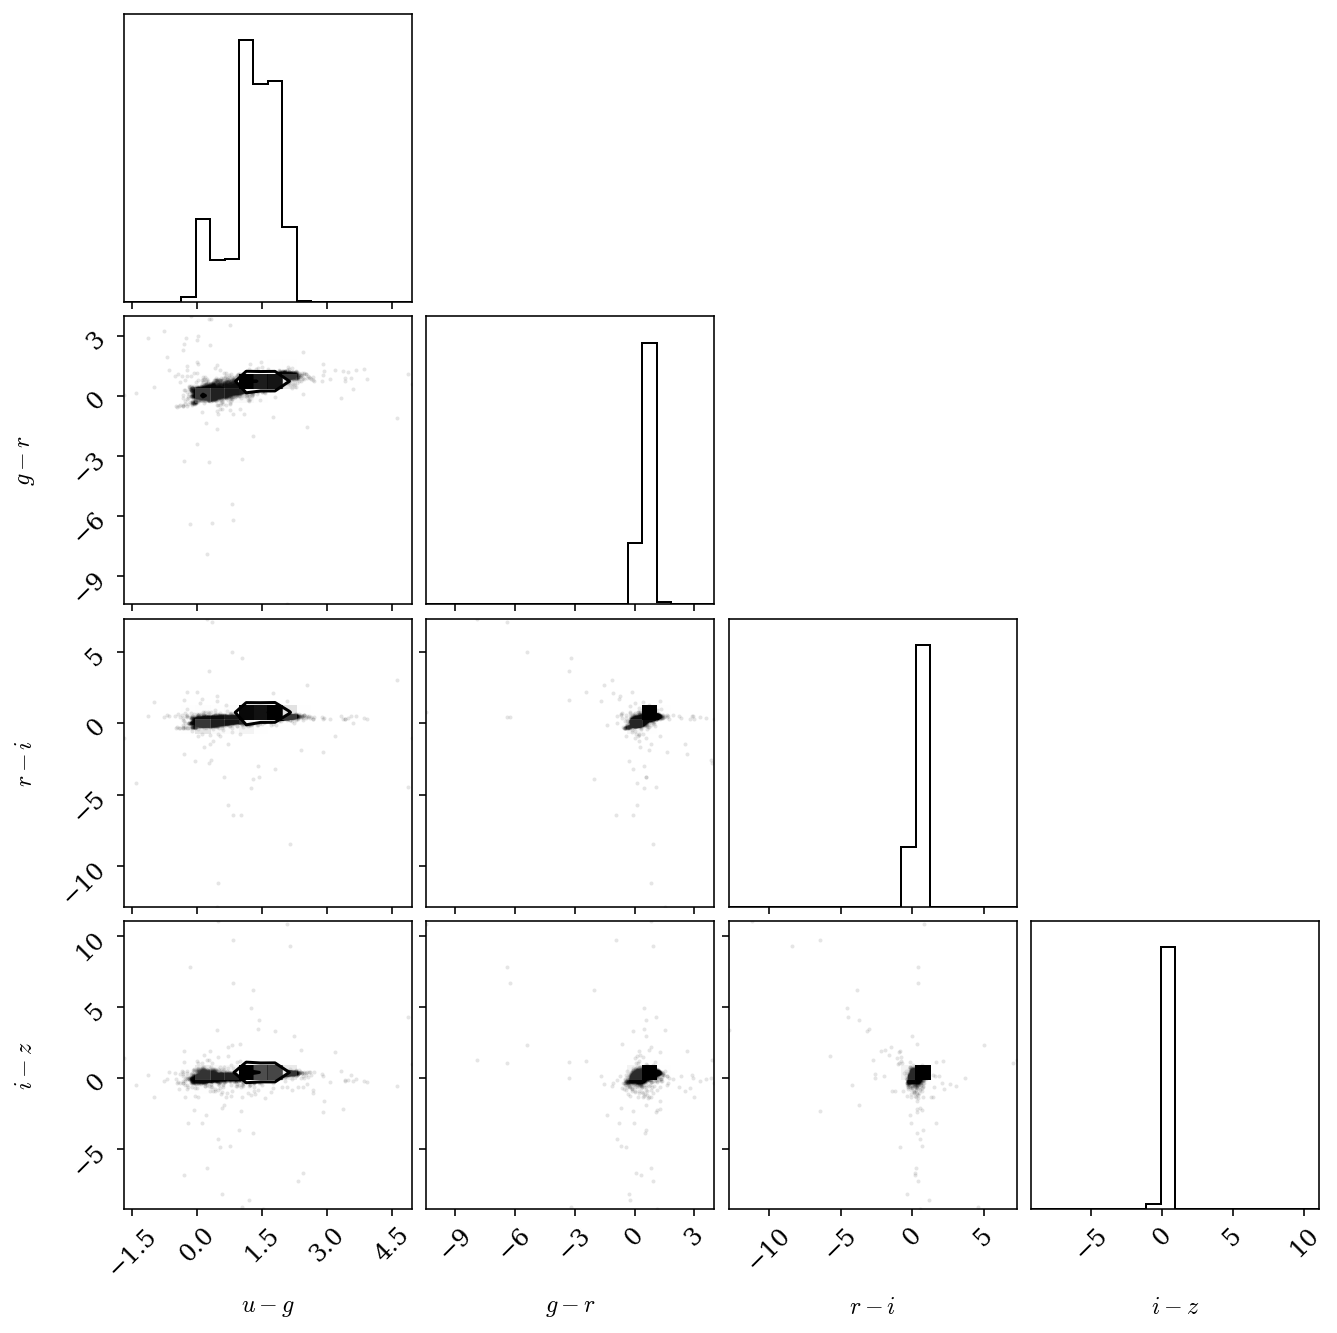

In [237]:
corner.corner(colors_train, labels = labels_corner);

$u-g$ is the most promising color 

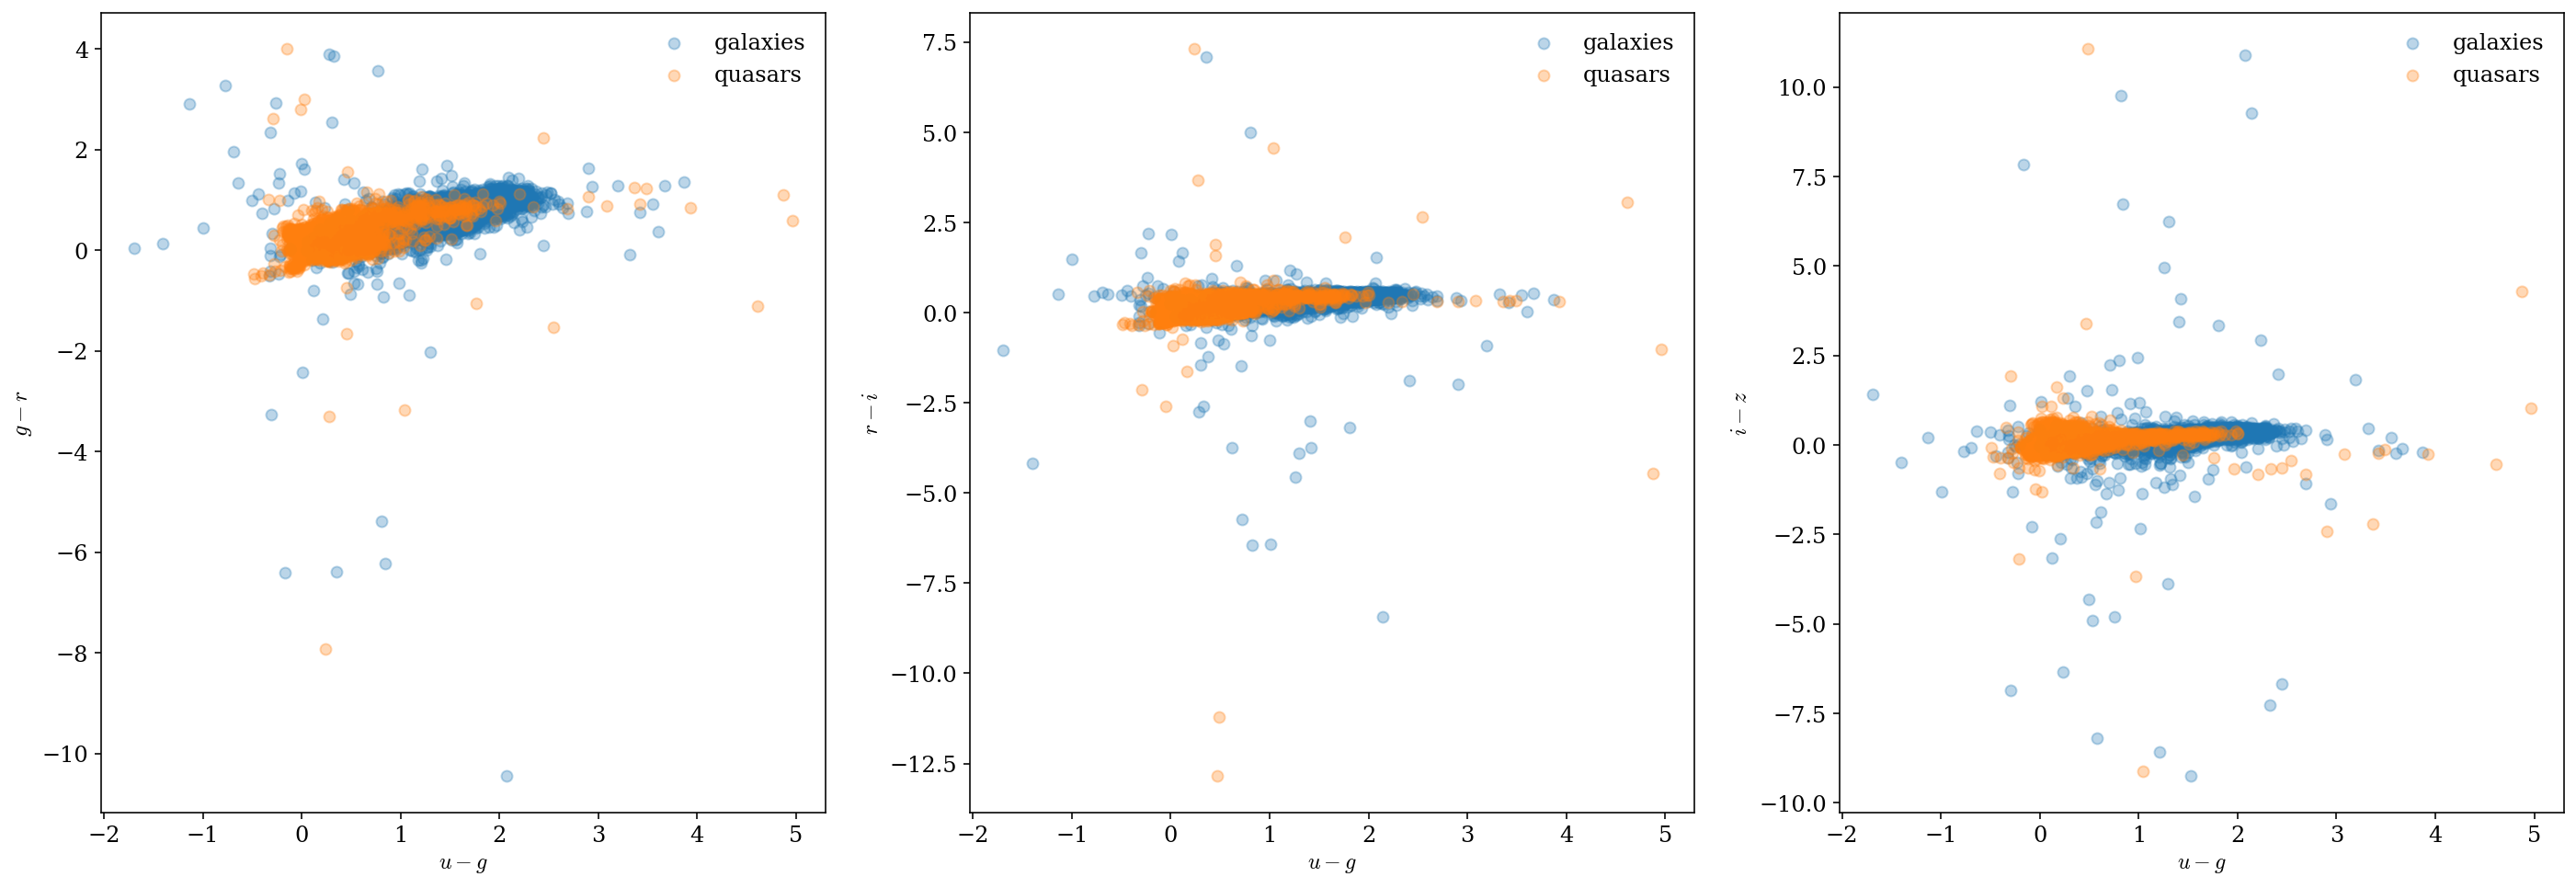

In [238]:
fig, axs = plt.subplots(1,3, figsize = (24,8))

axs[0].scatter(ug_train[labels_train == 0], gr_train[labels_train == 0], alpha=0.3, label='galaxies')
axs[0].scatter(ug_train[labels_train == 1], gr_train[labels_train == 1], alpha=0.3, label='quasars')
axs[0].set_xlabel(r'$u-g$') 
axs[0].set_ylabel(r'$g-r$')
axs[0].legend(frameon = False)

axs[1].scatter(ug_train[labels_train == 0], ri_train[labels_train == 0], alpha=0.3, label='galaxies')
axs[1].scatter(ug_train[labels_train == 1], ri_train[labels_train == 1], alpha=0.3, label='quasars')
axs[1].set_xlabel(r'$u-g$') 
axs[1].set_ylabel(r'$r-i$')
axs[1].legend(frameon = False)

axs[2].scatter(ug_train[labels_train == 0], iz_train[labels_train == 0], alpha=0.3, label='galaxies')
axs[2].scatter(ug_train[labels_train == 1], iz_train[labels_train == 1], alpha=0.3, label='quasars')
axs[2].set_xlabel(r'$u-g$') 
axs[2].set_ylabel(r'$i-z$')
axs[2].legend(frameon = False)

plt.show()

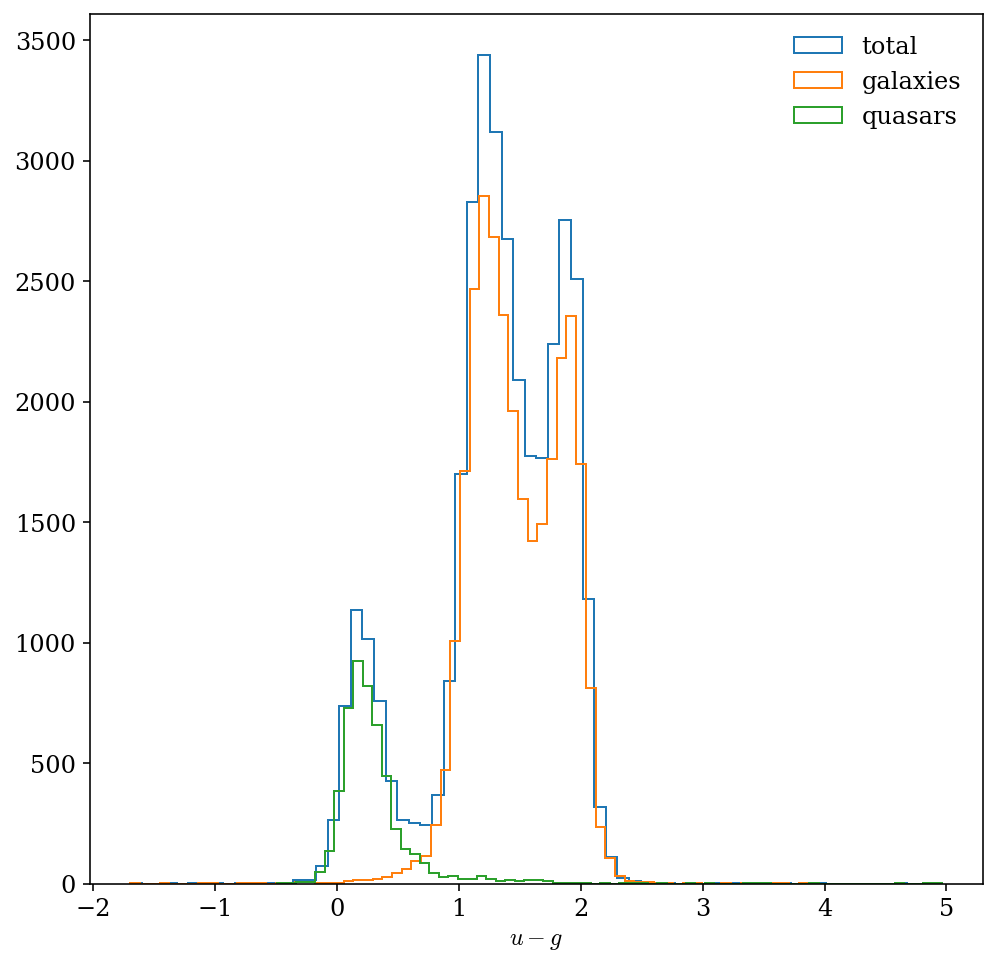

In [239]:
plt.hist(ug_train, bins = 70, histtype = 'step', label='total')
plt.hist(ug_train[labels_train == 0], bins = 70, histtype = 'step', label='galaxies')
plt.hist(ug_train[labels_train == 1], bins = 70, histtype = 'step', label='quasars')

plt.xlabel(r'$u-g$')
plt.legend(frameon = False)
plt.show()

## Classification

In [240]:
def return_accuracy(pred, test):
    true = len(pred[pred == test])
    return true / len(test)

In [241]:
accuracy = [] #best accuracy for each classifier
best_N = [] #number @ which the best accuracy is achieved 

### Gaussian naive bayes

In [242]:
classifiers, labels_pred, labels_proba = [], [], []
N = colors_train.shape[1] + 1
for n in range(1, N): #try with different colors
    X_train = colors_train[:,0:n]
    X_test = colors_test[:,0:n]

    clf = GaussianNB()
    clf.fit(X_train, labels_train)

    classifiers.append(clf)

    labels_pred.append(clf.predict(X_test))
    labels_proba.append(clf.predict_proba(X_test)[:,1])

In [243]:
# Compute the decision boundary
clf = classifiers[1] #2 colors
xlim = (min(X_train[:,0]), max(X_train[:,0]))
ylim = (min(X_train[:,1]), max(X_train[:,1]))

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

In [244]:
# ROC curve
fpr_list, tpr_list, thresh_list = [], [], []

for proba in labels_proba:
    fpr, tpr, thresh = roc_curve(labels_test, proba) #false and true positive rate + treshold
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    thresh_list.append(thresh)

In [245]:
#contamination and completeness
completeness, contamination = completeness_contamination(labels_pred, labels_test)
print('completeness: ', completeness)
print('contamination: ', contamination)

completeness:  [0.93612965 0.92993327 0.92421354 0.92421354]
contamination:  [0.0629771  0.10463515 0.10603965 0.11055046]


In [246]:
#accuracy
accuracy_NB = []
for pred in labels_pred:
    acc = return_accuracy(pred, labels_test)
    accuracy_NB.append(acc)
accuracy.append(max(accuracy_NB))
best_N.append(range(1,len(labels_pred)+1)[np.argmax(accuracy_NB)])

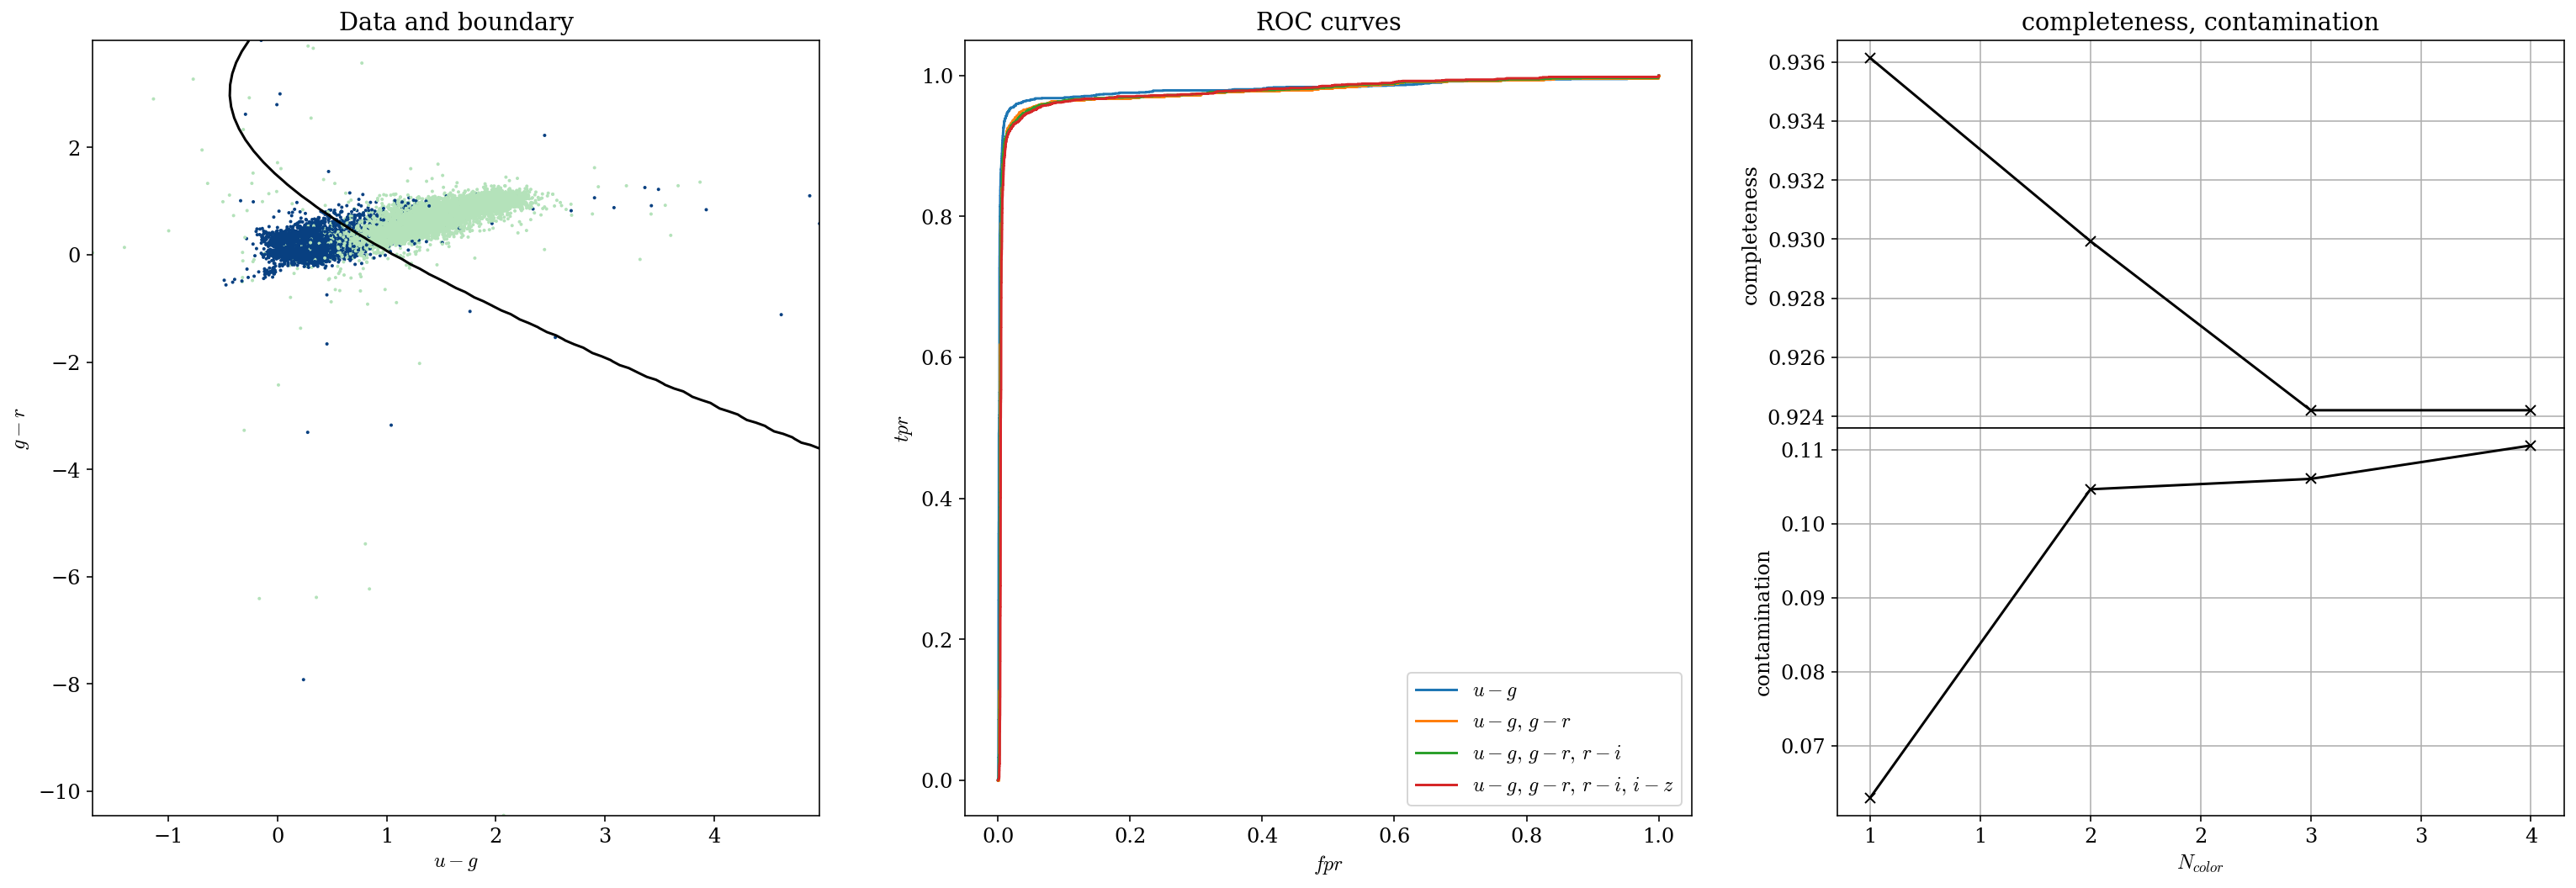

In [247]:
fig = plt.figure(figsize=(24, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)
ax1 = plt.subplot(131) #data: u-g vs g-r
ax2 = plt.subplot(132) #roc curves
ax3 = plt.subplot(233) #completeness
ax4 = plt.subplot(236) #contamination
#------------------------------------------------------------
im = ax1.scatter(X_train[:, 0], X_train[:, 1], c=labels_train,
                s=4, lw=0, cmap=plt.cm.GnBu, zorder=2)
im.set_clim(-0.5, 1)

ax1.contour(xx, yy, Z, [0.5], colors='k')

ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

ax1.set_xlabel(r'$u-g$')
ax1.set_ylabel(r'$g-r$')
ax1.set_title('Data and boundary')
#------------------------------------------------------------
labels_plot = [r'$u-g$', r'$u-g, \,g-r$', r'$u-g, \,g-r, \,r-i$', r'$u-g, \,g-r, \,r-i, \,i-z$']
for fpr, tpr, label in zip(fpr_list, tpr_list, labels_plot):
    ax2.plot(fpr, tpr, label = label)
    ax2.legend()
    
ax2.set_xlabel(r'$fpr$')
ax2.set_ylabel(r'$tpr$')
ax2.set_title('ROC curves')
#------------------------------------------------------------
ax3.plot(range(1,N), completeness, 'x-k')
ax3.set_ylabel('completeness')
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.set_title('completeness, contamination')
ax3.grid(True)
#------------------------------------------------------------
ax4.plot(range(1,N), contamination, 'x-k')
ax4.set_xlabel(r'$N_{color}$')
ax4.set_ylabel('contamination')
ax4.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax4.grid(True)
#------------------------------------------------------------
plt.show()

**$u-g$ is the most important feature** (as expected from the corner plot, it's the only color with a relevant variability)  
The ROC curve gets worse adding more colors probably because the assumption of conditional independence doesn't hold anymore.

### GMM Bayes

In [248]:
classifiers, labels_pred, labels_proba = [], [], []
N = colors_train.shape[1] + 1

for n in range(1, N): #try with different colors
    X_train = colors_train[:,0:n]
    X_test = colors_test[:,0:n]
    
    clf = GMMBayes(5)
    clf.fit(X_train, labels_train)

    classifiers.append(clf)

    labels_pred.append(clf.predict(X_test))
    labels_proba.append(clf.predict_proba(X_test)[:,1])

In [249]:
# Compute the decision boundary
clf = classifiers[1] #2 colors
xlim = (min(X_train[:,0]), max(X_train[:,0]))
ylim = (min(X_train[:,1]), max(X_train[:,1]))

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

In [250]:
# ROC curve
fpr_list, tpr_list, thresh_list = [], [], []

for proba in labels_proba:
    fpr, tpr, thresh = roc_curve(labels_test, proba) #false and true positive rate + treshold
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    thresh_list.append(thresh)

In [251]:
#contamination and completeness
completeness, contamination = completeness_contamination(labels_pred, labels_test)
print('completeness: ', completeness)
print('contamination: ', contamination)

completeness:  [0.93660629 0.93326978 0.94041945 0.93708294]
contamination:  [0.07485876 0.07291667 0.05189813 0.0470189 ]


In [252]:
#accuracy
accuracy_GMM = []
for pred in labels_pred:
    acc = return_accuracy(pred, labels_test)
    accuracy_GMM.append(acc)
accuracy.append(max(accuracy_GMM))
best_N.append(range(1,len(labels_pred)+1)[np.argmax(accuracy_GMM)])

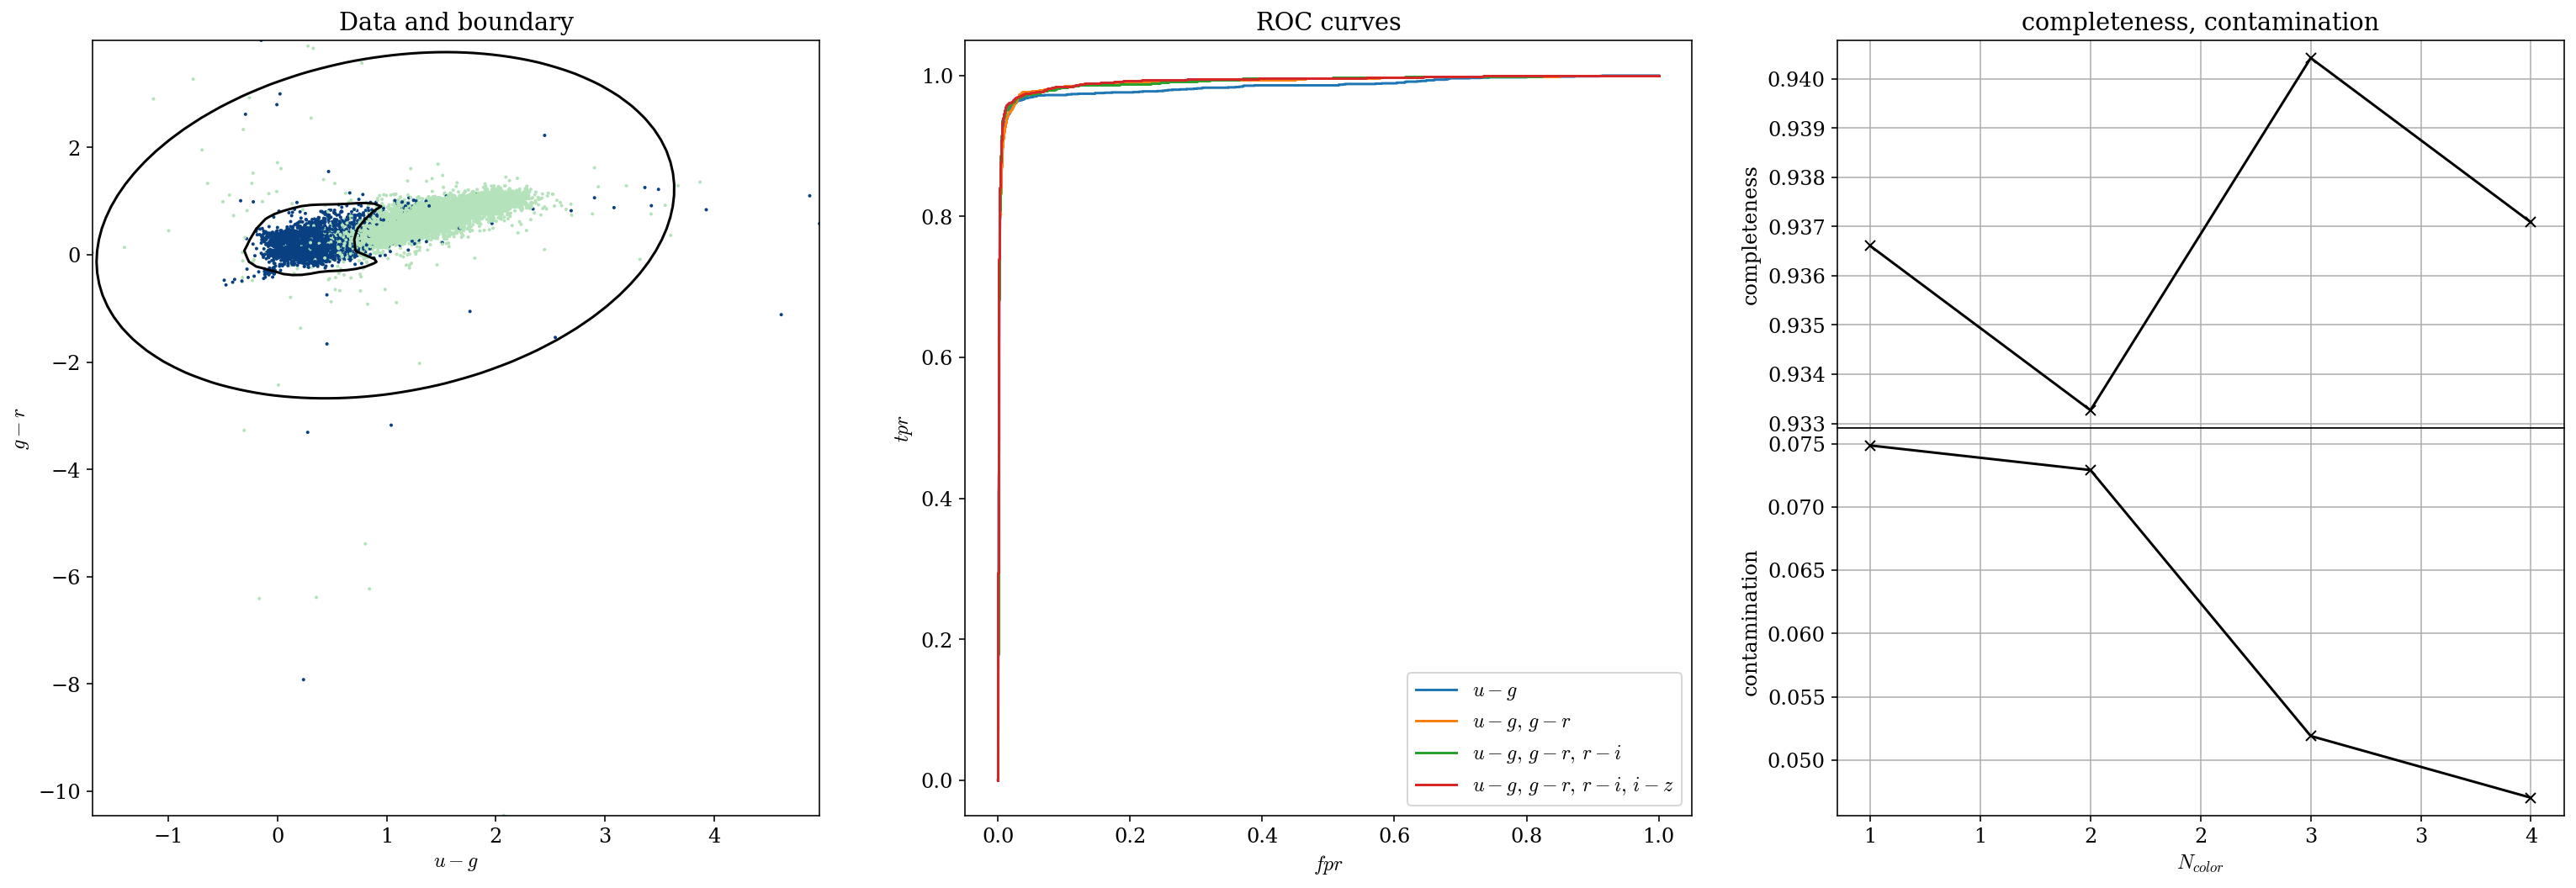

In [253]:
fig = plt.figure(figsize=(24, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)
ax1 = plt.subplot(131) #data: u-g vs g-r
ax2 = plt.subplot(132) #roc curves
ax3 = plt.subplot(233) #completeness
ax4 = plt.subplot(236) #contamination
#------------------------------------------------------------
im = ax1.scatter(X_train[:, 0], X_train[:, 1], c=labels_train,
                s=4, lw=0, cmap=plt.cm.GnBu, zorder=2)
im.set_clim(-0.5, 1)

ax1.contour(xx, yy, Z, [0.5], colors='k')

ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

ax1.set_xlabel(r'$u-g$')
ax1.set_ylabel(r'$g-r$')
ax1.set_title('Data and boundary')
#------------------------------------------------------------
labels_plot = [r'$u-g$', r'$u-g, \,g-r$', r'$u-g, \,g-r, \,r-i$', r'$u-g, \,g-r, \,r-i, \,i-z$']
for fpr, tpr, label in zip(fpr_list, tpr_list, labels_plot):
    ax2.plot(fpr, tpr, label = label)
    ax2.legend()
    
ax2.set_xlabel(r'$fpr$')
ax2.set_ylabel(r'$tpr$')
ax2.set_title('ROC curves')
#------------------------------------------------------------
ax3.plot(range(1,N), completeness, 'x-k')
ax3.set_ylabel('completeness')
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.set_title('completeness, contamination')
ax3.grid(True)
#------------------------------------------------------------
ax4.plot(range(1,N), contamination, 'x-k')
ax4.set_xlabel(r'$N_{color}$')
ax4.set_ylabel('contamination')
ax4.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax4.grid(True)
#------------------------------------------------------------
plt.show()

### K-Nearest Neighbor

In [254]:
def CV(X_train, labels_train, kvals):
    grid = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': kvals}, cv = 5)
    grid.fit(X_train, labels_train)
    best_k = grid.best_params_['n_neighbors']
    return best_k

In [255]:
classifiers, labels_pred, labels_proba = [], [], []
N = colors_train.shape[1] + 1
kvals = np.arange(1,15)
k_used = []
for n in range(1, N): #try with different colors
    X_train = colors_train[:,0:n]
    X_test = colors_test[:,0:n]
    #-- CV
    best_k = CV(X_train, labels_train, kvals)
    print(best_k)
    k_used.append(best_k)
    #–-
    clf = KNeighborsClassifier(n_neighbors = best_k)
    clf.fit(X_train, labels_train)

    classifiers.append(clf)

    labels_pred.append(clf.predict(X_test))
    labels_proba.append(clf.predict_proba(X_test)[:,1])

13
14
11
8


In [256]:
# Compute the decision boundary
clf = classifiers[1] #2 colors
xlim = (min(X_train[:,0]), max(X_train[:,0]))
ylim = (min(X_train[:,1]), max(X_train[:,1]))

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

In [257]:
# ROC curve
fpr_list, tpr_list, thresh_list = [], [], []

for proba in labels_proba:
    fpr, tpr, thresh = roc_curve(labels_test, proba)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    thresh_list.append(thresh)

In [258]:
#contamination and completeness
completeness, contamination = completeness_contamination(labels_pred, labels_test)
print('completeness: ', completeness)
print('contamination: ', contamination)

completeness:  [0.91992374 0.93183985 0.9399428  0.93898951]
contamination:  [0.05761719 0.05372701 0.04826255 0.03525955]


In [259]:
#accuracy
accuracy_k = []
for pred in labels_pred:
    acc = return_accuracy(pred, labels_test)
    accuracy_k.append(acc)
accuracy.append(max(accuracy_k))
best_N.append(range(1,len(labels_pred) + 1)[np.argmax(accuracy_k)])

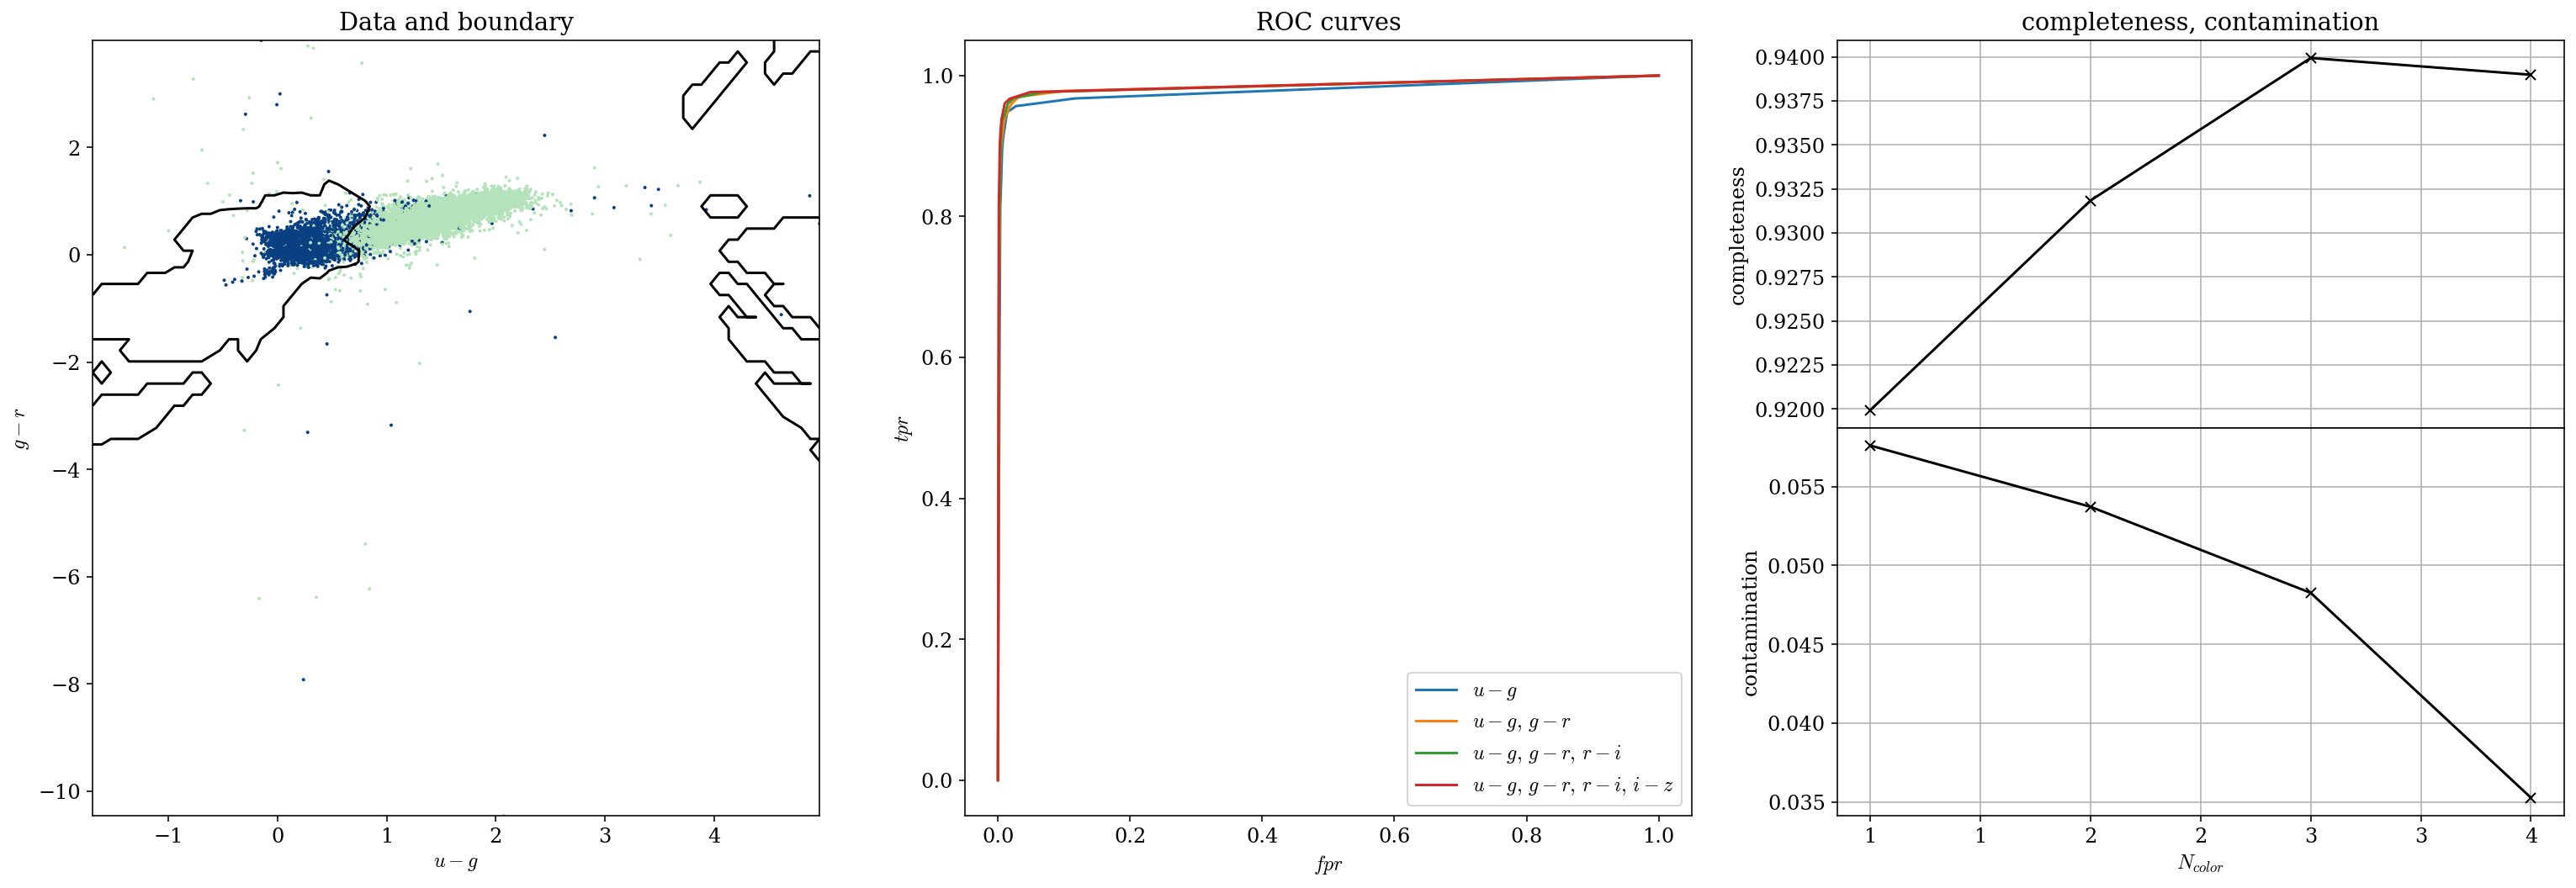

In [260]:
fig = plt.figure(figsize=(24, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)
ax1 = plt.subplot(131) #data: u-g vs g-r
ax2 = plt.subplot(132) #roc curves
ax3 = plt.subplot(233) #completeness
ax4 = plt.subplot(236) #contamination
#------------------------------------------------------------
im = ax1.scatter(X_train[:, 0], X_train[:, 1], c=labels_train,
                s=4, lw=0, cmap=plt.cm.GnBu, zorder=2)
im.set_clim(-0.5, 1)

ax1.contour(xx, yy, Z, [0.5], colors='k')

ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

ax1.set_xlabel(r'$u-g$')
ax1.set_ylabel(r'$g-r$')
ax1.set_title('Data and boundary')
#------------------------------------------------------------
labels_plot = [r'$u-g$', r'$u-g, \,g-r$', r'$u-g, \,g-r, \,r-i$', r'$u-g, \,g-r, \,r-i, \,i-z$']
for fpr, tpr, label in zip(fpr_list, tpr_list, labels_plot):
    ax2.plot(fpr, tpr, label = label)
    ax2.legend()
    
ax2.set_xlabel(r'$fpr$')
ax2.set_ylabel(r'$tpr$')
ax2.set_title('ROC curves')
#------------------------------------------------------------
ax3.plot(range(1,N), completeness, 'x-k')
ax3.set_ylabel('completeness')
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.set_title('completeness, contamination')
ax3.grid(True)
#------------------------------------------------------------
ax4.plot(range(1,N), contamination, 'x-k')
ax4.set_xlabel(r'$N_{color}$')
ax4.set_ylabel('contamination')
ax4.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax4.grid(True)
#------------------------------------------------------------
plt.show()

In [261]:
print('The cross validated numbers of neighbors are: ')
for i, k in enumerate(k_used):
    i+=1
    if i == 1:
        print('%i for %i color' % (k,i))
    else:
        print('%i for %i colors' % (k,i))

The cross validated numbers of neighbors are: 
13 for 1 color
14 for 2 colors
11 for 3 colors
8 for 4 colors


In [262]:
methods = ['Gaussian naive bayes', 'GMM Bayes', 'K-Nearest Neighbor']
for name, acc, n in zip(methods, accuracy, best_N):
    print(name + ': accuracy = %.4f for Ncolors = %i' % (acc, n))

Gaussian naive bayes: accuracy = 0.9823 for Ncolors = 1
GMM Bayes: accuracy = 0.9847 for Ncolors = 4
K-Nearest Neighbor: accuracy = 0.9867 for Ncolors = 4


### -----

## TensorFlow  
use all the colors

In [263]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import os
from time import time

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [264]:
#clean the log directory
#uncomment the right one
#clean = True
clean = False
if clean == True:
    !rm -rf ./logs/
    !rm -rf ./logsL19_trained/

    #trained model
    !rm -rf ./L19_trained.h5

In [265]:
layers_list = [1,2]
neurons_list = np.arange(2, 2*len(colors_train[0]) + 1).tolist()
lr_list = np.linspace(1e-3, 1e-1, 10).tolist()
act_list = ['relu', 'tanh']

In [266]:
#hyperparameters: CV the number of neurons, the activation function and the lr
HP_NUM_LAYERS = hp.HParam('num_layers', hp.Discrete(layers_list))
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete(neurons_list))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete(neurons_list))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete(lr_list))
HP_ACT_FUNCTION_1 = hp.HParam('activation_1', hp.Discrete(act_list))
HP_ACT_FUNCTION_2 = hp.HParam('activation_2', hp.Discrete(act_list))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/L19_hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_LAYERS, HP_NUM_UNITS_1, HP_NUM_UNITS_2, HP_LEARNING_RATE, HP_ACT_FUNCTION_1, HP_ACT_FUNCTION_2],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [267]:
#functions
#---
def rescale_colors(colors):
    rescaled_colors = np.zeros_like(colors)
    for i in range(len(colors[0])):
        lims = min(colors[:,i]), max(colors[:,i])
        rescaled_colors[:,i] = 1 - 2 * (colors[:, i] - lims[0]) / (lims[1] - lims[0])
    return rescaled_colors
#---
#CV for the hyperparams
def train_test_model(colors_train, labels_train, colors_test, labels_test, hparams):

    train_in  = rescale_colors(colors_train)
    train_out = labels_train
    test_in  = rescale_colors(colors_test)
    test_out = labels_test

    # Kernel initializer
    my_init = tf.keras.initializers.glorot_uniform(seed=1)
    # Define neural network architecture
    model = tf.keras.Sequential([
        # Input layer, do not change
        tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
        # Inner layers, can add/change
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS_1], activation=hparams[HP_ACT_FUNCTION_1], kernel_initializer=my_init),
        ])
    
    #eventual second layer
    if HP_NUM_LAYERS == 2:
        model.add(tf.keras.layers.Dense(hparams[HP_NUM_UNITS_2], activation=hparams[HP_ACT_FUNCTION_2], kernel_initializer=my_init))
    
    #output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid',kernel_initializer=my_init))
    
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE]),
        loss = 'binary_crossentropy',
        metrics=['accuracy'])

    model.fit(colors_train, labels_train, epochs=5) 
    _, accuracy = model.evaluate(colors_test, labels_test)
    return accuracy
#---
def run(run_dir, colors_train, labels_train, colors_test, labels_test, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(colors_train, labels_train, colors_test, labels_test, hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
    return accuracy
#---
def trainnetwork(colors_train, labels_train, colors_test, labels_test, hparams, filename='L19_trained.h5'):

    if not os.path.isfile(filename):

        train_in  = rescale_colors(colors_train)
        train_out = labels_train
        test_in  = rescale_colors(colors_test)
        test_out = labels_test

        # Kernel initializer
        my_init = tf.keras.initializers.glorot_uniform(seed=1)
        # Define neural network architecture
        model = tf.keras.Sequential([
            # Input layer, do not change
            tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
            # Inner layers, can add/change
            tf.keras.layers.Dense(hparams[HP_NUM_UNITS_1], activation=hparams[HP_ACT_FUNCTION_1], kernel_initializer=my_init),
            ])
    
         #eventual second layer
        if HP_NUM_LAYERS == 2:
            model.add(tf.keras.layers.Dense(hparams[HP_NUM_UNITS_2], activation=hparams[HP_ACT_FUNCTION_2], kernel_initializer=my_init))
    
        #output layer
        model.add(tf.keras.layers.Dense(1, activation='sigmoid',kernel_initializer=my_init))
    
        model.compile(
            # Optimization algorithm
            optimizer = tf.keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE]),
            # Loss function for a binary classifier
            loss='binary_crossentropy',
            # Diagnostic quantities
            metrics=['accuracy'])

        # Decrease the learning rate exponentially after the first 10 epochs
        def scheduler(epoch, lr):
            if epoch < 10:
                return lr
            else:
                return lr * tf.math.exp(-0.05)

        # Actual Training
        history = model.fit(
            # Training inputs
            train_in,
            # Training outputs
            train_out,
            # Evaluate test set at each epoch
            validation_data=(test_in, test_out),
            # Batch size, default is 32
            #batch_size=32,
            # Number of epochs
            epochs=150,
            # Store the model with the best validation accuracy
            callbacks = [
                # Drecrease learning rate
                tf.keras.callbacks.LearningRateScheduler(scheduler),
                # Store the model with the best validation accuracy
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
                # Save logfiles for tensorboard
                tf.keras.callbacks.TensorBoard(log_dir="logs"+filename.split('.h5')[0], histogram_freq=1)],
            # Shuffle data at each epoch
            shuffle=True)

    model = loadnetwork(filename)
    return model
#---
def loadnetwork(filename,verbose=False):
    '''
    Load a trained neural network
    '''

    model = tf.keras.models.load_model(filename)
    if verbose:
        model.summary()

    return model
#---
def testnetwork(model, colors_test, labels_test):
    '''
    Test network 
    '''
    test_in  = rescale_colors(colors_test)
    test_out = labels_test
    model.evaluate(test_in,  test_out, verbose=2)
#---
def predictnetwork(model, colors_test):
    '''
    Use a network to predict the class.
    '''
    # Return the class (0 or 1) that is preferred
    predictions = np.squeeze((model.predict(rescale_colors(colors_test)) > 0.5).astype("int32"))
    return predictions

In [268]:
#trained file:
filename='L19_trained.h5'

how much does the CV on a grid take? 

In [269]:
hparams = {
            HP_NUM_LAYERS: 0,
            HP_NUM_UNITS_1: 0,
            HP_NUM_UNITS_2: 0,
            HP_LEARNING_RATE: 0,
            HP_ACT_FUNCTION_1: 0,
            HP_ACT_FUNCTION_2: 0
        }
#VALIDATION
if not os.path.isfile(filename):
    tmp = time()
    accuracy_best = 0
    session_num = 0

    for num_layers in HP_NUM_LAYERS.domain.values:
        for num_units_1 in HP_NUM_UNITS_1.domain.values:
            for lr in HP_LEARNING_RATE.domain.values:
                for activation_1 in HP_ACT_FUNCTION_1.domain.values:
                    if num_layers == 1:
                        hparams = {
                                    HP_NUM_LAYERS: num_layers,
                                    HP_NUM_UNITS_1: num_units_1,
                                    HP_NUM_UNITS_2: 0,
                                    HP_LEARNING_RATE: lr,
                                    HP_ACT_FUNCTION_1: activation_1,
                                    HP_ACT_FUNCTION_2: 0
                                    }
                        run_name = "run-%d" % session_num
                        print('--- Starting trial: %s' % run_name)
                        print({h.name: hparams[h] for h in hparams})
                        accuracy_try = run('logs/hparam_tuning/' + run_name, colors_train, labels_train, colors_test, labels_test, hparams)
                        session_num += 1
        
                        if accuracy_try > accuracy_best:
                            accuracy_best = accuracy_try
                                    
                            best_num_layers = num_layers
                            best_num_units_1 = num_units_1
                            best_num_units_2 = 0
                            best_lr = lr
                            best_activation_1 = activation_1
                            best_activation_2 = 0
                            
                    elif num_layers == 2:
                        for num_units_2 in HP_NUM_UNITS_2.domain.values:
                            for activation_2 in HP_ACT_FUNCTION_2.domain.values:
                                hparams = {
                                            HP_NUM_LAYERS: num_layers,
                                            HP_NUM_UNITS_1: num_units_1,
                                            HP_NUM_UNITS_2: num_units_2,
                                            HP_LEARNING_RATE: lr,
                                            HP_ACT_FUNCTION_1: activation_1,
                                            HP_ACT_FUNCTION_2: activation_2
                                    }
                                run_name = "run-%d" % session_num
                                print('--- Starting trial: %s' % run_name)
                                print({h.name: hparams[h] for h in hparams})
                                accuracy_try = run('logs/hparam_tuning/' + run_name, colors_train, labels_train, colors_test, labels_test, hparams)
                                session_num += 1
        
                                if accuracy_try > accuracy_best:
                                    accuracy_best = accuracy_try
                                    
                                    best_num_layers = num_layers
                                    best_num_units_1 = num_units_1
                                    best_num_units_2 = num_units_2
                                    best_lr = lr
                                    best_activation_1 = activation_1
                                    best_activation_2 = activation_2
            
    hparams = {
            HP_NUM_LAYERS: best_num_layers,
            HP_NUM_UNITS_1: best_num_units_1,
            HP_NUM_UNITS_2: best_num_units_2,
            HP_LEARNING_RATE: best_lr,
            HP_ACT_FUNCTION_1: best_activation_1,
            HP_ACT_FUNCTION_2: best_activation_2
        }
    print(hparams)
    print(accuracy_best)
    
    tmp = time() - tmp
    print('---- \nThe cross validation took %.2f s' % tmp)

In [270]:
model = trainnetwork(colors_train, labels_train, colors_test, labels_test, hparams, filename=filename)

**accuracy of the NN with CV on the whole grid:**

In [271]:
testnetwork(model, colors_test, labels_test)

469/469 - 1s - loss: 0.0719 - accuracy: 0.9831 - 649ms/epoch - 1ms/step


In [272]:
%tensorboard --logdir logs/hparam_tuning

on my machine the full CV on grid took ~$17$ hours! How do the hyperparameters and accuracy change with different approaches?

## Compare it with the random and LHC approach

In [273]:
#trained files:
filename_random = 'L19_trained_random.h5'
filename_LHC = 'L19_trained_LHC.h5'

#try both methods with 100 samples
N = 100

### random approach

In [274]:
if not os.path.isfile(filename_random):
    tmp = time()
    accuracy_best = 0
    session_num = 0
    for i in range(N):
        n_layers_try = np.random.choice(layers_list)
        n_hidden_1_try = np.random.choice(neurons_list)
        lr_try = np.random.choice(lr_list)
        act_1_try = np.random.choice(act_list)
        n_hidden_2_try = act_2_try = 0
        
        if n_layers_try == 2:
            n_hidden_2_try = np.random.choice(neurons_list)
            act_2_try = np.random.choice(act_list)
        
        hparams = {
                    HP_NUM_LAYERS: n_layers_try,
                    HP_NUM_UNITS_1: n_hidden_1_try,
                    HP_NUM_UNITS_2: n_hidden_2_try,
                    HP_LEARNING_RATE: lr_try,
                    HP_ACT_FUNCTION_1: act_1_try,
                    HP_ACT_FUNCTION_2: act_2_try
                    }
        
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        accuracy_try = run('logs/hparam_tuning/random/' + run_name, colors_train, labels_train, colors_test, labels_test, hparams)
        session_num += 1
        
        if accuracy_try > accuracy_best:
            accuracy_best = accuracy_try
                                    
            best_num_layers = n_layers_try
            best_num_units_1 = n_hidden_1_try
            best_num_units_2 = n_hidden_2_try
            best_lr = lr_try
            best_activation_1 = act_1_try
            best_activation_2 = act_2_try
            
    hparams = {
            HP_NUM_LAYERS: best_num_layers,
            HP_NUM_UNITS_1: best_num_units_1,
            HP_NUM_UNITS_2: best_num_units_2,
            HP_LEARNING_RATE: best_lr,
            HP_ACT_FUNCTION_1: best_activation_1,
            HP_ACT_FUNCTION_2: best_activation_2
        }
    print(hparams)
    print(accuracy_best)
    
    tmp = time() - tmp
    print('---- \nThe cross validation took %.2f s' % tmp)

--- Starting trial: run-0
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 5, 'learning_rate': 0.023000000000000003, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 4s 3ms/step - loss: 0.1201 - accuracy: 0.9735
Epoch 2/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0789 - accuracy: 0.9815
Epoch 3/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0747 - accuracy: 0.9819
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0750 - accuracy: 0.9823
Epoch 5/5
469/469 [==============================] - 2s 1ms/step - loss: 0.0630 - accuracy: 0.9847
--- Starting trial: run-1
{'num_layers': 1, 'num_units_1': 8, 'num_units_2': 0, 'learning_rate': 0.045000000000000005, 'activation_1': 'tanh', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0740 - accuracy: 0.9803
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step 

469/469 [==============================] - 1s 1ms/step - loss: 0.0582 - accuracy: 0.9842
--- Starting trial: run-11
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 3, 'learning_rate': 0.067, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0911 - accuracy: 0.9781
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0848 - accuracy: 0.9808
Epoch 3/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0766 - accuracy: 0.9811
Epoch 4/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0785 - accuracy: 0.9809
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0652 - accuracy: 0.9831
--- Starting trial: run-12
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 5, 'learning_rate': 0.023000000000000003, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0810 - acc

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0683 - accuracy: 0.9829
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0647 - accuracy: 0.9842
--- Starting trial: run-22
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 4, 'learning_rate': 0.045000000000000005, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0996 - accuracy: 0.9755
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0869 - accuracy: 0.9805
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0858 - accuracy: 0.9821
Epoch 4/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0852 - accuracy: 0.9812
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0822 - accuracy: 0.9827
--- Starting trial: run-23
{'num_layers': 1, 'num_units_1': 4, 'num_units_2': 0, 'learning_rate': 0.034, 'activation_1': 'relu', 'activatio

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0750 - accuracy: 0.9813
Epoch 4/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0756 - accuracy: 0.9814
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0641 - accuracy: 0.9834
--- Starting trial: run-33
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 2, 'learning_rate': 0.045000000000000005, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0751 - accuracy: 0.9789
Epoch 2/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0630 - accuracy: 0.9831
Epoch 3/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0614 - accuracy: 0.9838
Epoch 4/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0621 - accuracy: 0.9836
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0641 - accuracy: 0.9809
--- Starting trial: run-34
{'num_layer

1094/1094 [==============================] - 2s 2ms/step - loss: 0.1165 - accuracy: 0.9729
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0847 - accuracy: 0.9793
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0772 - accuracy: 0.9807
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0677 - accuracy: 0.9828
--- Starting trial: run-44
{'num_layers': 1, 'num_units_1': 2, 'num_units_2': 0, 'learning_rate': 0.001, 'activation_1': 'tanh', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.3119 - accuracy: 0.8793
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1367 - accuracy: 0.9720
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0904 - accuracy: 0.9794
Epoch 4/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0778 - accuracy: 0.9805
Epoch 5/5
469/469 [==============================] - 1s 

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0909 - accuracy: 0.9781
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0824 - accuracy: 0.9805
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0850 - accuracy: 0.9807
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0842 - accuracy: 0.9799
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0748 - accuracy: 0.9831
--- Starting trial: run-55
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 7, 'learning_rate': 0.067, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0835 - accuracy: 0.9753
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0684 - accuracy: 0.9821
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0662 - accuracy: 0.9829
Epoch 4/5
1094/1094 [==============================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0964 - accuracy: 0.9781
Epoch 2/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0872 - accuracy: 0.9819
Epoch 3/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0838 - accuracy: 0.9811
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0817 - accuracy: 0.9817
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0821 - accuracy: 0.9811
--- Starting trial: run-66
{'num_layers': 2, 'num_units_1': 2, 'num_units_2': 4, 'learning_rate': 0.001, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.3129 - accuracy: 0.8561
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1900 - accuracy: 0.9053
Epoch 3/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1381 - accuracy: 0.9639
Epoch 4/5
1094/1094 [====================

Epoch 1/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0826 - accuracy: 0.9759
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0647 - accuracy: 0.9824
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0637 - accuracy: 0.9833
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0626 - accuracy: 0.9833
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0558 - accuracy: 0.9845
--- Starting trial: run-77
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 3, 'learning_rate': 0.034, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0799 - accuracy: 0.9776
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0660 - accuracy: 0.9827
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0642 - accuracy: 0.9827
Epoch 4/5
1094/1094 [====================

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0712 - accuracy: 0.9814
Epoch 2/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0652 - accuracy: 0.9830
Epoch 3/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0657 - accuracy: 0.9827
Epoch 4/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0649 - accuracy: 0.9829
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0605 - accuracy: 0.9835
--- Starting trial: run-88
{'num_layers': 1, 'num_units_1': 5, 'num_units_2': 0, 'learning_rate': 0.08900000000000001, 'activation_1': 'tanh', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0805 - accuracy: 0.9762
Epoch 2/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0655 - accuracy: 0.9824
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0646 - accuracy: 0.9831
Epoch 4/5
1094/1094 [===========

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.2655 - accuracy: 0.9063
Epoch 2/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0925 - accuracy: 0.9785
Epoch 3/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0822 - accuracy: 0.9796
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0804 - accuracy: 0.9800
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0753 - accuracy: 0.9821
--- Starting trial: run-99
{'num_layers': 2, 'num_units_1': 5, 'num_units_2': 4, 'learning_rate': 0.023000000000000003, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0928 - accuracy: 0.9758
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0802 - accuracy: 0.9819
Epoch 3/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0776 - accuracy: 0.9821
Epoch 4/5
1094/1094 [=====

In [275]:
model_random = trainnetwork(colors_train, labels_train, colors_test, labels_test, hparams, filename=filename_random)

Epoch 1/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0957 - accuracy: 0.9743 - val_loss: 0.2541 - val_accuracy: 0.8891 - lr: 0.0340
Epoch 2/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0769 - accuracy: 0.9809 - val_loss: 0.2957 - val_accuracy: 0.8797 - lr: 0.0340
Epoch 3/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0746 - accuracy: 0.9808 - val_loss: 0.1868 - val_accuracy: 0.9275 - lr: 0.0340
Epoch 4/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0734 - accuracy: 0.9818 - val_loss: 0.1634 - val_accuracy: 0.9370 - lr: 0.0340
Epoch 5/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0728 - accuracy: 0.9812 - val_loss: 0.1782 - val_accuracy: 0.9331 - lr: 0.0340
Epoch 6/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0726 - accuracy: 0.9815 - val_loss: 0.1503 - val_accuracy: 0.9469 - lr: 0.0340
Epoch 7/150
1094/1094 [=============================

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0641 - accuracy: 0.9839 - val_loss: 0.2759 - val_accuracy: 0.8605 - lr: 0.0042
Epoch 53/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0641 - accuracy: 0.9835 - val_loss: 0.2772 - val_accuracy: 0.8606 - lr: 0.0040
Epoch 54/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0640 - accuracy: 0.9837 - val_loss: 0.2696 - val_accuracy: 0.8607 - lr: 0.0038
Epoch 55/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0638 - accuracy: 0.9836 - val_loss: 0.2729 - val_accuracy: 0.8607 - lr: 0.0036
Epoch 56/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0639 - accuracy: 0.9836 - val_loss: 0.2790 - val_accuracy: 0.8607 - lr: 0.0034
Epoch 57/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0638 - accuracy: 0.9837 - val_loss: 0.2822 - val_accuracy: 0.8606 - lr: 0.0032
Epoch 58/150
1094/1094 [==============================] - 2

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0633 - accuracy: 0.9837 - val_loss: 0.2895 - val_accuracy: 0.8607 - lr: 3.2510e-04
Epoch 104/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0633 - accuracy: 0.9838 - val_loss: 0.2909 - val_accuracy: 0.8607 - lr: 3.0924e-04
Epoch 105/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0633 - accuracy: 0.9839 - val_loss: 0.2896 - val_accuracy: 0.8607 - lr: 2.9416e-04
Epoch 106/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0633 - accuracy: 0.9838 - val_loss: 0.2887 - val_accuracy: 0.8607 - lr: 2.7981e-04
Epoch 107/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0633 - accuracy: 0.9838 - val_loss: 0.2895 - val_accuracy: 0.8607 - lr: 2.6617e-04
Epoch 108/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0632 - accuracy: 0.9838 - val_loss: 0.2901 - val_accuracy: 0.8607 - lr: 2.5318e-04
Epoch 109/150
1094/1094 [=====

**accuracy of the NN with CV relying on random sampling:**

In [276]:
testnetwork(model_random, colors_test, labels_test)

469/469 - 1s - loss: 0.0863 - accuracy: 0.9767 - 612ms/epoch - 1ms/step


This random approach on my machine took ~$20$ minutes

### LHC approach

In [277]:
from scipy.stats.qmc import LatinHypercube

In [278]:
if not os.path.isfile(filename_LHC):
    sampler = LatinHypercube(d = len(hparams))
    tmp = time()
    accuracy_best = 0
    session_num = 0
    for i in range(N):
        sample = sampler.random()
        
        n_layers_try = layers_list[int(np.rint(sample[0][0]))]
        n_hidden_1_try = int(np.rint(min(neurons_list) + sample[0][1] * (max(neurons_list) - min(neurons_list))))
        lr_try = lr_list[int(np.rint(sample[0][2]))]
        act_1_try = act_list[int(np.rint(sample[0][3]))]
        n_hidden_2_try = act_2_try = 0
        
        if n_layers_try == 2:
            n_hidden_2_try = int(np.rint(min(neurons_list) + sample[0][4] * (max(neurons_list) - min(neurons_list))))
            act_2_try = act_list[int(np.rint(sample[0][5]))]
        
        hparams = {
                    HP_NUM_LAYERS: n_layers_try,
                    HP_NUM_UNITS_1: n_hidden_1_try,
                    HP_NUM_UNITS_2: n_hidden_2_try,
                    HP_LEARNING_RATE: lr_try,
                    HP_ACT_FUNCTION_1: act_1_try,
                    HP_ACT_FUNCTION_2: act_2_try
                    }
        
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        accuracy_try = run('logs/hparam_tuning/LHC/' + run_name, colors_train, labels_train, colors_test, labels_test, hparams)
        session_num += 1
        
        if accuracy_try > accuracy_best:
            accuracy_best = accuracy_try
                                    
            best_num_layers = n_layers_try
            best_num_units_1 = n_hidden_1_try
            best_num_units_2 = n_hidden_2_try
            best_lr = lr_try
            best_activation_1 = act_1_try
            best_activation_2 = act_2_try
            
    hparams = {
            HP_NUM_LAYERS: best_num_layers,
            HP_NUM_UNITS_1: best_num_units_1,
            HP_NUM_UNITS_2: best_num_units_2,
            HP_LEARNING_RATE: best_lr,
            HP_ACT_FUNCTION_1: best_activation_1,
            HP_ACT_FUNCTION_2: best_activation_2
        }
    print(hparams)
    print(accuracy_best)
    
    tmp = time() - tmp
    print('---- \nThe cross validation took %.2f s' % tmp)

--- Starting trial: run-0
{'num_layers': 2, 'num_units_1': 6, 'num_units_2': 4, 'learning_rate': 0.001, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1870 - accuracy: 0.9270
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0879 - accuracy: 0.9783
Epoch 3/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0776 - accuracy: 0.9801
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0750 - accuracy: 0.9807
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0682 - accuracy: 0.9833
--- Starting trial: run-1
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 8, 'learning_rate': 0.001, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.2346 - accuracy: 0.9155
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0861 - accuracy

Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1019 - accuracy: 0.9711
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0741 - accuracy: 0.9820
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0729 - accuracy: 0.9824
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0701 - accuracy: 0.9826
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0597 - accuracy: 0.9835
--- Starting trial: run-12
{'num_layers': 2, 'num_units_1': 3, 'num_units_2': 6, 'learning_rate': 0.012, 'activation_1': 'tanh', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0879 - accuracy: 0.9749
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0671 - accuracy: 0.9828
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0651 - accuracy: 0.9829
Epoch 4/5
1094/1094 [====================

1094/1094 [==============================] - 2s 2ms/step - loss: 0.1015 - accuracy: 0.9668
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0678 - accuracy: 0.9825
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0647 - accuracy: 0.9833
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0632 - accuracy: 0.9836
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0556 - accuracy: 0.9853
--- Starting trial: run-23
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 4, 'learning_rate': 0.012, 'activation_1': 'relu', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0959 - accuracy: 0.9734
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0773 - accuracy: 0.9816
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0728 - accuracy: 0.9812
Epoch 4/5
1094/1094 [==============================

1094/1094 [==============================] - 2s 2ms/step - loss: 0.2341 - accuracy: 0.8827
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1406 - accuracy: 0.9652
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1127 - accuracy: 0.9764
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0996 - accuracy: 0.9783
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0878 - accuracy: 0.9818
--- Starting trial: run-34
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 4, 'learning_rate': 0.012, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0986 - accuracy: 0.9721
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0788 - accuracy: 0.9816
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0749 - accuracy: 0.9818
Epoch 4/5
1094/1094 [==============================

1094/1094 [==============================] - 2s 2ms/step - loss: 0.1669 - accuracy: 0.9593
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0756 - accuracy: 0.9819
Epoch 3/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0735 - accuracy: 0.9818
Epoch 4/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0721 - accuracy: 0.9821
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0678 - accuracy: 0.9847
--- Starting trial: run-45
{'num_layers': 2, 'num_units_1': 7, 'num_units_2': 6, 'learning_rate': 0.001, 'activation_1': 'tanh', 'activation_2': 'relu'}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.4000 - accuracy: 0.7799
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1577 - accuracy: 0.9511
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0986 - accuracy: 0.9776
Epoch 4/5
1094/1094 [==============================

1094/1094 [==============================] - 4s 3ms/step - loss: 0.2781 - accuracy: 0.9068
Epoch 2/5
1094/1094 [==============================] - 3s 3ms/step - loss: 0.0915 - accuracy: 0.9789
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0812 - accuracy: 0.9803
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0793 - accuracy: 0.9805
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0731 - accuracy: 0.9826
--- Starting trial: run-56
{'num_layers': 1, 'num_units_1': 7, 'num_units_2': 0, 'learning_rate': 0.012, 'activation_1': 'tanh', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 4s 3ms/step - loss: 0.0928 - accuracy: 0.9722
Epoch 2/5
1094/1094 [==============================] - 3s 2ms/step - loss: 0.0684 - accuracy: 0.9827
Epoch 3/5
1094/1094 [==============================] - 4s 4ms/step - loss: 0.0667 - accuracy: 0.9825
Epoch 4/5
1094/1094 [==============================] - 3

1094/1094 [==============================] - 2s 2ms/step - loss: 0.2656 - accuracy: 0.8886
Epoch 2/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0995 - accuracy: 0.9774
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0816 - accuracy: 0.9807
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0784 - accuracy: 0.9808
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0715 - accuracy: 0.9829
--- Starting trial: run-67
{'num_layers': 1, 'num_units_1': 8, 'num_units_2': 0, 'learning_rate': 0.012, 'activation_1': 'relu', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.1010 - accuracy: 0.9725
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0740 - accuracy: 0.9823
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0711 - accuracy: 0.9825
Epoch 4/5
1094/1094 [==============================] - 2

1094/1094 [==============================] - 2s 2ms/step - loss: 0.1915 - accuracy: 0.9235
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0867 - accuracy: 0.9789
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0770 - accuracy: 0.9812
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0744 - accuracy: 0.9819
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.0674 - accuracy: 0.9841
--- Starting trial: run-78
{'num_layers': 1, 'num_units_1': 6, 'num_units_2': 0, 'learning_rate': 0.012, 'activation_1': 'tanh', 'activation_2': 0}
Epoch 1/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0989 - accuracy: 0.9685
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0681 - accuracy: 0.9826
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0641 - accuracy: 0.9831
Epoch 4/5
1094/1094 [==============================] - 2

1094/1094 [==============================] - 2s 2ms/step - loss: 0.2565 - accuracy: 0.8988
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0985 - accuracy: 0.9766
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0795 - accuracy: 0.9802
Epoch 4/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0754 - accuracy: 0.9812
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0674 - accuracy: 0.9829
--- Starting trial: run-89
{'num_layers': 2, 'num_units_1': 8, 'num_units_2': 5, 'learning_rate': 0.012, 'activation_1': 'relu', 'activation_2': 'tanh'}
Epoch 1/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0952 - accuracy: 0.9724
Epoch 2/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0761 - accuracy: 0.9811
Epoch 3/5
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0729 - accuracy: 0.9813
Epoch 4/5
1094/1094 [==============================

1094/1094 [==============================] - 2s 1ms/step - loss: 0.0977 - accuracy: 0.9731
Epoch 2/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0773 - accuracy: 0.9815
Epoch 3/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0754 - accuracy: 0.9820
Epoch 4/5
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0734 - accuracy: 0.9821
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.0626 - accuracy: 0.9839
{HParam(name='num_layers', domain=Discrete([1, 2]), display_name=None, description=None): 1, HParam(name='num_units_1', domain=Discrete([2, 3, 4, 5, 6, 7, 8]), display_name=None, description=None): 8, HParam(name='num_units_2', domain=Discrete([2, 3, 4, 5, 6, 7, 8]), display_name=None, description=None): 0, HParam(name='learning_rate', domain=Discrete([0.001, 0.012, 0.023000000000000003, 0.034, 0.045000000000000005, 0.05600000000000001, 0.067, 0.07800000000000001, 0.08900000000000001, 0.1]), display_na

In [279]:
model_LHC = trainnetwork(colors_train, labels_train, colors_test, labels_test, hparams, filename=filename_LHC)

Epoch 1/150
1094/1094 [==============================] - 3s 2ms/step - loss: 0.1094 - accuracy: 0.9665 - val_loss: 0.2804 - val_accuracy: 0.8787 - lr: 0.0120
Epoch 2/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0816 - accuracy: 0.9803 - val_loss: 0.2938 - val_accuracy: 0.8777 - lr: 0.0120
Epoch 3/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0795 - accuracy: 0.9803 - val_loss: 0.3055 - val_accuracy: 0.8739 - lr: 0.0120
Epoch 4/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0772 - accuracy: 0.9808 - val_loss: 0.2849 - val_accuracy: 0.8816 - lr: 0.0120
Epoch 5/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0755 - accuracy: 0.9806 - val_loss: 0.2548 - val_accuracy: 0.8919 - lr: 0.0120
Epoch 6/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0746 - accuracy: 0.9809 - val_loss: 0.2527 - val_accuracy: 0.8960 - lr: 0.0120
Epoch 7/150
1094/1094 [=============================

1094/1094 [==============================] - 2s 2ms/step - loss: 0.0642 - accuracy: 0.9828 - val_loss: 0.1202 - val_accuracy: 0.9591 - lr: 0.0015
Epoch 53/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0641 - accuracy: 0.9832 - val_loss: 0.1236 - val_accuracy: 0.9565 - lr: 0.0014
Epoch 54/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0640 - accuracy: 0.9832 - val_loss: 0.1186 - val_accuracy: 0.9605 - lr: 0.0013
Epoch 55/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0641 - accuracy: 0.9831 - val_loss: 0.1282 - val_accuracy: 0.9535 - lr: 0.0013
Epoch 56/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0640 - accuracy: 0.9829 - val_loss: 0.1219 - val_accuracy: 0.9577 - lr: 0.0012
Epoch 57/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0641 - accuracy: 0.9833 - val_loss: 0.1144 - val_accuracy: 0.9625 - lr: 0.0011
Epoch 58/150
1094/1094 [==============================] - 2

1094/1094 [==============================] - 3s 2ms/step - loss: 0.0635 - accuracy: 0.9834 - val_loss: 0.1112 - val_accuracy: 0.9651 - lr: 1.2062e-04
Epoch 103/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0635 - accuracy: 0.9834 - val_loss: 0.1091 - val_accuracy: 0.9663 - lr: 1.1474e-04
Epoch 104/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0635 - accuracy: 0.9833 - val_loss: 0.1089 - val_accuracy: 0.9663 - lr: 1.0914e-04
Epoch 105/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0635 - accuracy: 0.9834 - val_loss: 0.1097 - val_accuracy: 0.9660 - lr: 1.0382e-04
Epoch 106/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0635 - accuracy: 0.9834 - val_loss: 0.1104 - val_accuracy: 0.9655 - lr: 9.8757e-05
Epoch 107/150
1094/1094 [==============================] - 2s 2ms/step - loss: 0.0635 - accuracy: 0.9833 - val_loss: 0.1107 - val_accuracy: 0.9654 - lr: 9.3941e-05
Epoch 108/150
1094/1094 [=====

**accuracy of the NN with CV relying on a Latin hypercube:**

In [280]:
testnetwork(model_LHC, colors_test, labels_test)

469/469 - 1s - loss: 0.1059 - accuracy: 0.9675 - 656ms/epoch - 1ms/step


This LHC approach on my machine took ~$17$ minutes

## Summary

In [281]:
model.summary()

Model: "sequential_2115"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4230 (Dense)          (None, 4)                 20        
                                                                 
 dense_4231 (Dense)          (None, 1)                 5         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [282]:
model_random.summary()

Model: "sequential_511"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1022 (Dense)          (None, 4)                 20        
                                                                 
 dense_1023 (Dense)          (None, 1)                 5         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [283]:
model_LHC.summary()

Model: "sequential_612"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1224 (Dense)          (None, 8)                 40        
                                                                 
 dense_1225 (Dense)          (None, 1)                 9         
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


### warning  
Since I trained the first NN (the one with the full grid CV) without fixing the seed of the splitting train-test, the model loaded has been trained on a set different from the actual training set. This is the reason because the accuracy of that net is not as large as the others. I have trained from scratch only the NNs with the two faster approaches.  

Anyway, the table below shows the accuracy and required time for the three networks trained and tested on the same sets. 

Because of this, now I have fixed the seed of the the test_train_split to avoid to retrain also the last two networks.

## conclusion  

Results after the first run:  

| CV method | accuracy | time for CV|
|---|---|---|
| grid | 0.9828 | ~17 hours| 
| random (100 samples) | 0.9816 | ~20 min| 
| LHC (100 samples) | 0.9827 | ~17 minutes| 

The LHC approach provided basically the same accuracy of the full grid cross validation in something like ~$\frac{1}{60}$ of the time $\implies$ probably not worth to try a full grid search.  

**Anyways** all the three networks provided a sligthly less accurate classifier with respect to GMM bayes or k-neighbors $\implies$ a NN is not required to solve this problem, other faster classifiers can perform well enough.